In [1]:
from sklearn.neural_network import MLPClassifier as mlpClass
import sys
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML")
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML/FeH")
from fitsParser.fitsParser import fitsParser
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from numpy import linspace
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from modelValidator import psMetric, cut, shuffleDwarfs, plotRes, plot, norm_inputs, monte_carlo, printTable
from function import save_data


fits = fitsParser(includefile = 'fitsSetup.txt')
fits.makeColours(N=10)
colours = [ 'g-i', 'CaHK-g', 'u-g', 'CaHK-g', 'CaHK-i', 'z-y']
test_colours = ['pristine_col'+x for x in '1234']+['g-i', 'g-r']

def moreCols(fits):
    fits.data['pristine_col4'] = fits.data['u-g']-0.21
    fits.data['pristine_col1'] = fits.data['CaHK-g']*0.8
    fits.data['pristine_col2'] = fits.data['CaHK-g']*0.75
    fits.data['pristine_col3'] = fits.data['u-CaHK']-0.21
moreCols(fits)
sdss = fitsParser(includefile = 'FeHdata.txt')
colours = ['pristine_col', 'g-i', 'pristine_col2', 'g-r', 'u-g', 'u-CaHK']
#fits.data['u'] += 0.4 #compensate for percent level offset in ab magnitudes from sdss
colours = test_colours
data = pd.DataFrame(fits.data)
data = shuffle(data)
l = lambda col : (data[col]>0)&(data[col]<2)
#data = data[l('g-r')&l('g-i')]
data = data[data['FeH']<=-2]
#data['FeH'] += np.random.normal(scale = 0.15, size = len(data))

train_in, test_in, train_out, test_out = train_test_split(data[colours], data['FeH'], test_size = 0.2 , shuffle = False)
data['test_flag'] = [0]*len(train_in)+[1]*len(test_in)

Using TensorFlow backend.


In [2]:
params = {
        'hidden_layer_sizes' : (64, 64, 64 , 64, 64),
        'max_iter' : 500, 
        'verbose' : True,
        'batch_size' :100,
        'tol' : 1e-10
    }
X = LabelEncoder()
labels = X.fit_transform(np.ravel(train_out))
model = mlpClass(**params)
model.fit(train_in.values, labels)
data['FeH_pred'] = X.inverse_transform(model.predict(data[colours])) 

Iteration 1, loss = 0.92581925
Iteration 2, loss = 0.86160057
Iteration 3, loss = 0.77082985
Iteration 4, loss = 0.67206223
Iteration 5, loss = 0.60142832
Iteration 6, loss = 0.57982091
Iteration 7, loss = 0.54704746
Iteration 8, loss = 0.53167316
Iteration 9, loss = 0.49707354
Iteration 10, loss = 0.47381570
Iteration 11, loss = 0.46252789
Iteration 12, loss = 0.45580449
Iteration 13, loss = 0.45242911
Iteration 14, loss = 0.43150418
Iteration 15, loss = 0.42552954
Iteration 16, loss = 0.41587052
Iteration 17, loss = 0.41488383
Iteration 18, loss = 0.41816355
Iteration 19, loss = 0.40626039
Iteration 20, loss = 0.43244172
Iteration 21, loss = 0.39424531
Iteration 22, loss = 0.38889757
Iteration 23, loss = 0.38952905
Iteration 24, loss = 0.38255406
Iteration 25, loss = 0.39016056
Iteration 26, loss = 0.37891321
Iteration 27, loss = 0.36900773
Iteration 28, loss = 0.40280798
Iteration 29, loss = 0.38358055
Iteration 30, loss = 0.36562569
Iteration 31, loss = 0.36939290
Iteration 32, los

In [3]:
inc = [0,-1,-2,-2.5,-3,-4]
data['FeHadop'] = data['FeH']
pur, com = psMetric(data, inc = inc)
print printTable(inc , pur , com)

| [Fe/H]< | purity | completness |
----------------------------------
| 0.0     | 1.0000 | 1.0000      |
| -1.0    | 1.0000 | 1.0000      |
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.9613 | 0.7974      |
| -3.0    | 0.9613 | 0.7974      |
| -4.0    | 0.9537 | 0.4722      |



In [4]:
pre_transform = lambda l, bins : map(lambda x : 0 if x>=0 else   x + min([c-x for c in bins if x<=c]) , l)

def getMags(colour):
    return colour[:colour.index('-')], colour[colour.index('-')+1:]

sdss = fitsParser(includefile = 'FeHdata.txt')
youc = sdss.getAllObj()[1]
cut(youc, metThresh = -5)
youc.makeColours(N=10)
youc.makeColours(N=10)
conversion = {
    'CaHK_0' : 'CaHK' 
}
conversion.update({x+'_fpsf' : x for x in 'grizy'})
conversion.update({x+'_0' :x for x in 'ugri'})
for col in youc.colours:
    mag1, mag2 = getMags(col)
    youc.data[conversion[mag1]+'-'+conversion[mag2]] = youc.data[col]
    
youc.data['pristine_col4'] = youc.data['u-g']
youc.data['pristine_col1'] = youc.data['CaHK-g']
youc.data['pristine_col2'] = youc.data['CaHK-g']
youc.data['pristine_col3'] = youc.data['u-CaHK']

youc.data['FeH_bin'] = pre_transform(youc.data['FeHadop'], [1, 0.5, 0,-0.5,-1,-1.5,-2,-3,-4])
youc.data['FeH_pred'] = X.inverse_transform(model.predict(youc.data[colours]))
youc.data['FeH'] = youc.data['FeHadop']
youc.data['FeHadop'] = youc.data['FeH_bin']
youc.data['test_flag']=1
youc.data['res'] = youc.data['FeH_pred'] - youc.data['FeH_bin']
pur, com = psMetric(youc.data, inc = inc)
print printTable(inc,pur,com)



Data saved

condition on dFeHadop cut 17 inputs
2.99% of inputs cut
| [Fe/H]< | purity | completness |
----------------------------------
| 0.0     | 1.0000 | 1.0000      |
| -1.0    | 1.0000 | 1.0000      |
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.0894 | 0.6957      |
| -3.0    | 0.0894 | 0.6957      |
| -4.0    | 0.0000 | 0.0000      |



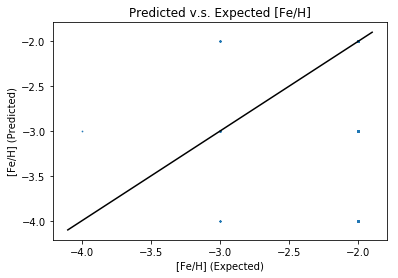

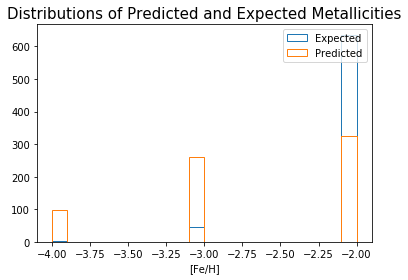

/home/watkinsz/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


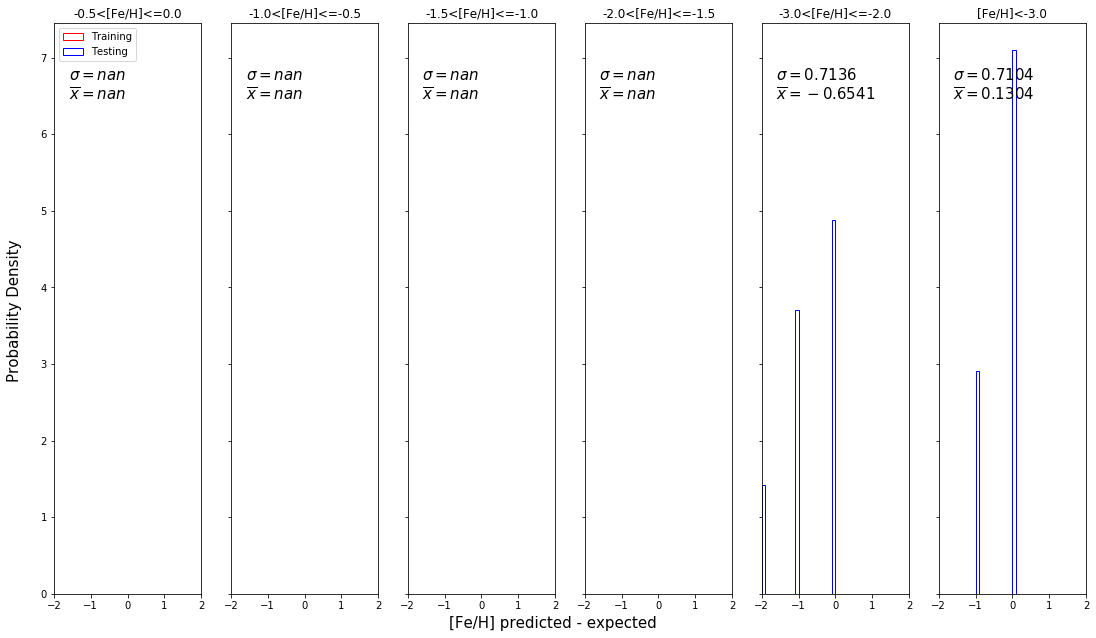


Data saved



In [5]:
def makePlots(outputSDSS, pred = 'FeH_pred', adop = 'FeH', res ='res'):
    #plot((outputSDSS[res])[outputSDSS['test_flag']==-1])

    plt.scatter(outputSDSS[adop], outputSDSS[pred] , s = 0.5)
    plt.title('Predicted v.s. Expected [Fe/H]')
    plt.xlabel('[Fe/H] (Expected)')
    plt.ylabel('[Fe/H] (Predicted)')
    x = np.linspace(max((plt.xlim())[0], (plt.ylim())[0]), min((plt.xlim())[1], (plt.ylim())[1]))
    plt.plot(x,x, color = 'black')
    plt.show()


    getbins = lambda data, size = 0.1 : np.arange(min(data), max(data) + size, size)
    den = False
    getNbins = lambda data, s ,size = 0.1 : int((np.max(data[s])-np.min(data[s]))/size)
    try:
        plt.hist((outputSDSS[pred])[outputSDSS['test_flag']==-1], bins  = getbins((outputSDSS[pred])[outputSDSS['test_flag']==-1]),  histtype = 'step', label = 'Predicted | [Fe/H]>%.1f'%metCut, density = den)
    except ValueError:
        pass
    plt.hist((outputSDSS[adop]), bins = getbins((outputSDSS[adop])), histtype = 'step', label = 'Expected', density = den)
    plt.hist((outputSDSS[pred])[outputSDSS['test_flag']>=0], bins=getbins((outputSDSS[pred])[outputSDSS['test_flag']>=0]),  histtype = 'step', label = 'Predicted', density = den)
    plt.xlabel('[Fe/H]')
    plt.title('Distributions of Predicted and Expected Metallicities', fontsize = 15)
    plt.legend(loc = 'upper right')
    plt.show()


    bins = [0, -0.5, -1,-1.5, -2 , -3]
    f,  z = plt.subplots(1, len(bins), sharex='all', sharey='row')
    plt.xlim(-2,2)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(bins)):
        if (i==len(bins)-1):
            sub = outputSDSS[outputSDSS[adop]<=bins[i]]
        else:
            sub = outputSDSS[(outputSDSS[adop]<=bins[i])&(outputSDSS[adop]>bins[i+1])]
        Title = '%.1f<[Fe/H]<=%.1f' %(bins[i+1] ,bins[i]) if i+1 in range(len(bins)) else '[Fe/H]<%.1f'%bins[i]
        plotRes((sub[sub['test_flag']!=0])[res], (sub[sub['test_flag']==0][res]), toPlot = z[i],title = Title, normalFit = False, xy = (0.1 , 0.9))
    z[0].legend(loc = 'upper left')
    f.text(0.5, 0.08, '[Fe/H] predicted - expected', ha='center', fontsize = 15)
    f.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 15)
    plt.show()
    
    
makePlots(youc.data, adop = 'FeH_bin')
save_data(youc.data, 'out1.asc')